Download and unzip [2014-08-01fish2_H2B/raw.zip](https://github.com/optofish-paper/ZebrafishFunctionalMaps_LinearRegression/blob/master/2014-08-01fish2_H2B/raw.zip?raw=true) (350 MB) before running this code.

In [1]:
# Thunder-related libraries, for image processing
import thunder as td
from registration import CrossCorr
from regression import FastLinearRegression

In [2]:
sparkOn = False  # True if Spark is installed and used as computation engine (on a cluster). 
                 # False if running the code in local mode

tifFormat = True  # True if images are TIFF files
                  # False if images in binary '*.stack' format (check correct dimensions for import) 

In [3]:
# standard libraries
import numpy as np 
import matplotlib.pyplot as plt
import sys
from skimage.external import tifffile
import glob
import os
# fish-specific modules:
sys.path.append('./lib')
import behavior
import compress
if sparkOn: 
    sc.addPyFile('./lib/compress.py')  # 'sc' stands for Spark context (set up in the clusted environment).
    
%matplotlib inline

In [4]:
# Set up your data directory
expDir = 'C:/Users/nvladim/Documents/GitHub/ZebrafishFunctionalMaps_LinearRegression/2014-08-01fish2_H2B/'
rawDir = expDir + 'raw/'  # storage of an imaging/behavior session
if not os.path.exists(rawDir):
    raise ValueError("Please check if ./raw folder exists")

procDir = expDir + 'proc/'  # storage for processed data (functional maps)
fName = 'ephys.10ch'
if not os.path.exists(procDir):
        os.mkdir(procDir)

In [5]:
# if using Spark, uncompress the imaging data from BZ2 files in parallel mode
if sparkOn: 
    fileList = glob.glob(rawDir + 'TM*.stack.bz2')
    sc.parallelize(fileList).foreach(compress.bz2_uncompress_stack)

### Parse behavior file

In [6]:
# read the behavior data
ephys = behavior.import10ch(rawDir + fName)
# down-sampled time series, by stack imaging rate, about 1.55 Hz
stack_init_ind = behavior.stack_onsets(ephys)
# drift is the speed of visual stimulus, can be positive (forward, tail-> head) or negative (backward, head->tail)
drift = np.squeeze(ephys['drift'][stack_init_ind])
drift_6kHz = np.squeeze(ephys['drift'][:]) 
f_drift = np.zeros(drift.shape)
f_drift_ind = np.where(drift > 0)[0]
f_drift[f_drift_ind] = drift[f_drift_ind]
f_drift_ind_6kHz = np.where(drift_6kHz > 0)[0]
b_drift = np.zeros(drift.shape)
b_drift_ind = np.where(drift < 0)[0]
b_drift[b_drift_ind] = -drift[b_drift_ind]

swim_fdrift_ch0_6kHz = np.zeros(ephys['fltCh0'][:].shape)
swim_fdrift_ch1_6kHz = np.zeros(ephys['fltCh1'][:].shape)
# fill channels with default values, using 50% percentile
swim_fdrift_ch0_6kHz[:] = np.percentile(ephys['fltCh0'][:], 50)
swim_fdrift_ch1_6kHz[:] = np.percentile(ephys['fltCh1'][:], 50)
# fill the rest with actual signal
swim_fdrift_ch0_6kHz[f_drift_ind_6kHz] = ephys['fltCh0'][f_drift_ind_6kHz]
swim_fdrift_ch1_6kHz[f_drift_ind_6kHz] = ephys['fltCh1'][f_drift_ind_6kHz]

# find peaks of behavior within stack duration
stack_duration_6kHz = np.diff(stack_init_ind)
swim_fdrift_ch0 = np.zeros(len(stack_init_ind))
swim_fdrift_ch1 = np.zeros(len(stack_init_ind))

for i in range(0, len(stack_init_ind) - 1):
    swim_fdrift_ch0[i] = np.max(swim_fdrift_ch0_6kHz[stack_init_ind[i]:stack_init_ind[i]+stack_duration_6kHz[i]])
    swim_fdrift_ch1[i] = np.max(swim_fdrift_ch1_6kHz[stack_init_ind[i]:stack_init_ind[i]+stack_duration_6kHz[i]])

# Adjust the baseline of behavior by clipping between lowest 1% and highest 99%, to avoid spiking artifacts
swim_fdrift = swim_fdrift_ch0 + swim_fdrift_ch1
swim_baseline = np.percentile(swim_fdrift, 1)
swim_fdrift = np.clip(swim_fdrift, swim_baseline, np.percentile(swim_fdrift, 99))
swim_fdrift -= swim_baseline

# Convolve the regressors with double-exp kernel to mimic GCAMP response
tau = 3.0  # decay constant, in stacks
tau1 = 1.0  # rise time, must be < tau

swim_fdrift_convolved = behavior.conv2exp(swim_fdrift, tau1, tau)
f_drift_convolved = behavior.conv2exp(f_drift, tau1, tau)
b_drift_convoled = behavior.conv2exp(b_drift, tau1, tau)

(0, 200)

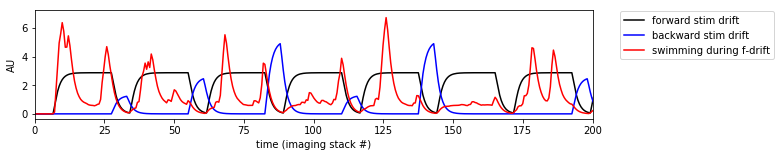

In [8]:
# plot the time series of convoled behavior variables
plt.figure(figsize=(10, 2))
plt.plot(ephys['t'][stack_init_ind], f_drift_convolved / f_drift_convolved.std(), '-k',label = 'forward stim drift')
plt.plot(ephys['t'][stack_init_ind], b_drift_convoled / b_drift_convoled.std(), '-b', label = 'backward stim drift')
plt.plot(ephys['t'][stack_init_ind], swim_fdrift_convolved / swim_fdrift_convolved.std(), 'r', label = 'swimming during f-drift')
plt.xlabel('time (imaging stack #)')
plt.ylabel('AU')
plt.legend(loc = (1.05,0.55))
plt.xlim(0, 200)

In [9]:
# Prepare regressors using cropped time series (100:200), corresponds to imaging stack series
stack_ind_range = np.arange(100, 200)
regressors = np.column_stack((
    swim_fdrift_convolved[stack_ind_range]/swim_fdrift_convolved[stack_ind_range].std(),
    f_drift_convolved[stack_ind_range]/f_drift_convolved[stack_ind_range].std(),
    b_drift_convoled[stack_ind_range]/b_drift_convoled[stack_ind_range].std()))
regressors.shape

(100L, 3L)

## Image processing (requires Thunder)

In [10]:
dims = (41, 256, 512)
n_stacks = 100
if sparkOn:
    # load images using distributed computing engine Spark
    if tifFormat:
        imaging_data = td.images.fromtif(rawDir, npartitions=n_stacks, engine=sc)
    else:
        imaging_data = td.images.frombinary(rawDir, shape=dims, ext='tif', npartitions=n_stacks, engine=sc)
else:
    # load images in local context
    if tifFormat:
        imaging_data = td.images.fromtif(rawDir, npartitions=n_stacks)
    else:
        imaging_data = td.images.frombinary(rawDir, shape=dims, ext='tif', npartitions=n_stacks)

# actually load the images, necessary due to 'lazy' execution in Spark.
imaging_data.count 

<bound method Images.count of Images
mode: local
dtype: uint16
shape: (100L, 41L, 256L, 512L)>

In [14]:
# create reference anatomy stack in ./proc folder
n_stacks_reference = 10
ref_stack = imaging_data[-n_stacks_reference:, :, :, :].mean().toarray()
tifffile.imsave(procDir + 'ref.tif', ref_stack.astype(np.uint16))

### Run registration using a cropped dataset

In [15]:
z_start = 10  # starting plane of registration 
z_end = 30  # ending plane of registration
stacks_cropped_zrange = imaging_data[:, z_start:z_end, :, :] 
reference = stacks_cropped_zrange[-n_stacks_reference:, :, :, :].mean().toarray()

register = CrossCorr(axis=0) 
model = register.fit(stacks_cropped_zrange.median_filter(3), reference=reference)
deltas = model.toarray()

# set registration shifts
xshift = np.floor(np.median(deltas[:,:,1],axis=1))
yshift = np.floor(np.median(deltas[:,:,0],axis=1))

for ti in range(len(model.transformations)):
    model.transformations[(ti,)].delta = []
    for zi in range(dims[0]):
        model.transformations[(ti,)].delta.append([yshift[ti],xshift[ti]])
        
# apply registration parameters to the full data    
imaging_data_registered = model.transform(imaging_data)

Horizontal lines mean there was no sample motion along x(y) axis during experiment


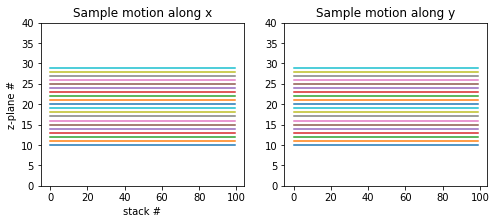

In [22]:
# Check XY sample motion during experiment 
f, axarr = plt.subplots(1, 2, figsize=(8, 3))
for x in range(deltas.shape[1]):
    axarr[0].plot(deltas[:,x,1] + x + z_start)   
    axarr[0].set_title('Sample motion along x')
    axarr[0].set_ylim(0, 40)
    axarr[0].set_xlabel('stack #')
    axarr[0].set_ylabel('z-plane #')
    
    axarr[1].plot(deltas[:, x, 0] + x + z_start)  
    axarr[1].set_title('Sample motion along y')
    axarr[1].set_ylim(0, 40)
print('Horizontal lines mean there was no sample motion along x(y) axis during experiment')

### Convert to time series and do linear regression

In [23]:
%%time
imaging_time_series = imaging_data_registered.toseries().normalize()
imaging_time_series.count()

Wall time: 8min 42s


In [24]:
%%time
model = FastLinearRegression(fit_intercept=True).fit(regressors, imaging_time_series)
results = model.betas_and_scores.toarray()
betas, r_squared = results[:, :, :, 1:4], results[:, :, :, 4]

# Convert (regression coeffs x R2) into weights
imMotorForw = (betas[:, :, :, 0] * r_squared)
imForw = (betas[:, :, :, 1] * r_squared)
imBackw = (betas[:, :, :, 2] * r_squared)

Wall time: 8min 15s


### Adjust gamma and save in RGB image (tiff) files

In [ ]:
# gamma-adjustment on positive weights
gamma = 0.5
imMgamma = np.zeros(imMotorForw.shape)
imMgamma[imMotorForw > 0] = imMotorForw[imMotorForw > 0]**gamma

imFgamma = np.zeros(imForw.shape)
imFgamma[imForw > 0] = imForw[imForw > 0]**gamma

imBgamma = np.zeros(imBackw.shape)
imBgamma[imBackw > 0] = imBackw[imBackw > 0]**gamma

# Save as 8-bit RGB tif files
imTiffR = imMgamma * 255
imTiffG = imFgamma * 255
imTiffB = imBgamma * 255
compositeTiff = np.array([imTiffR.T, imTiffG.T, imTiffB.T])

tifffile.imsave(procDir + 'motorDuringForw_REDgamma0.5.tif', imTiffR.astype(np.uint8))
tifffile.imsave(procDir + 'forwDrift_GREENgamma0.5.tif', imTiffG.astype(np.uint8))
tifffile.imsave(procDir + 'backwDrift_BLUEgamma0.5.tif', imTiffB.astype(np.uint8))
tifffile.imsave(procDir + 'compositeRGBgamma0.5.tif', compositeTiff.T.astype(np.uint8))

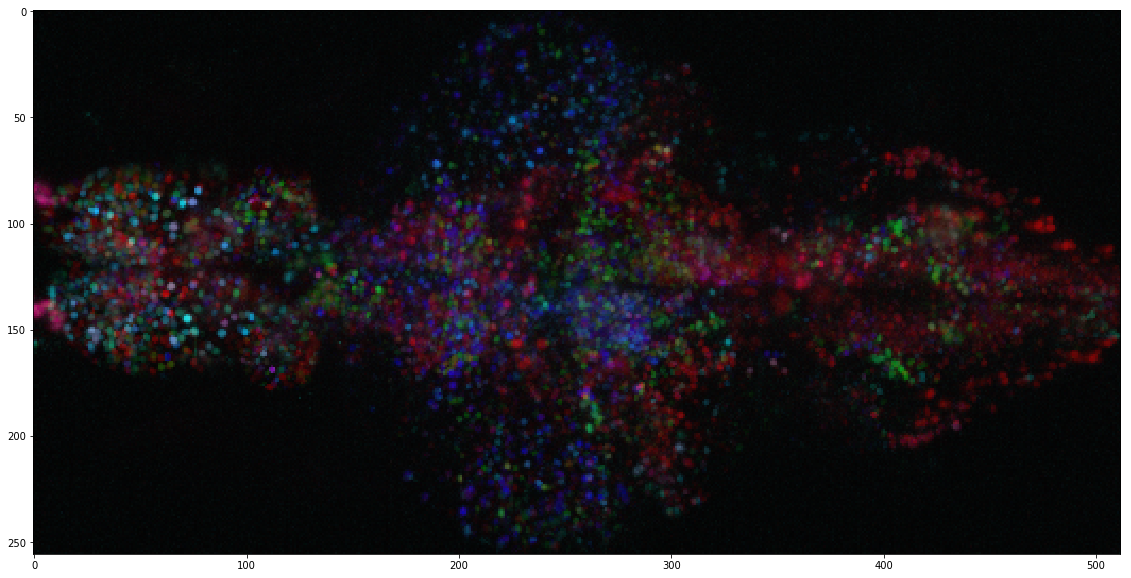

In [29]:
# Show max instensity projection
plt.figure(figsize=(20, 10))
plt.imshow(compositeTiff.max(axis=3).T.astype(np.uint8))